In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, ZeroPadding2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, Add, MaxPooling2D, RandomFlip, RandomRotation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform, random_uniform

2024-02-28 23:09:29.130816: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 23:09:29.159363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 23:09:29.159397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 23:09:29.160473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 23:09:29.165657: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 23:09:29.166280: I tensorflow/core/platform/cpu_feature_guard.cc:1

Dataset preparation


In [4]:
#Names of all classes according to folder names
class_names = os.listdir('data')
print(class_names)


#Creating dataset from folders
dataset = tf.keras.utils.image_dataset_from_directory(
    'data',
    labels='inferred',
    label_mode='categorical',
    class_names = class_names,
    color_mode= 'rgb',
    batch_size = 32,
    image_size = (128,128),
    shuffle = True,
    seed = 99,)   

['Apple___alternaria_leaf_spot', 'Apple___black_rot', 'Apple___brown_spot']
Found 1114 files belonging to 3 classes.


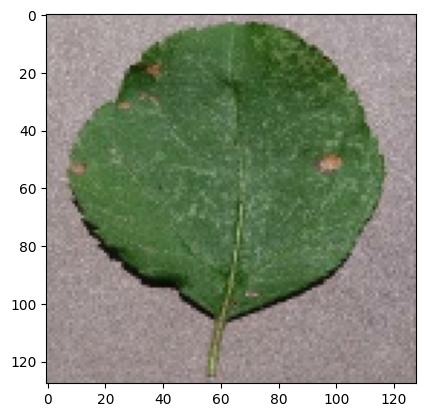

In [5]:
#Plot random image
sample = dataset.take(1)

for img, label in sample:
    plot = plt.subplot()
    plot.imshow(img[0]/255)

In [18]:
#Train-test split

DATASET_SIZE = len(dataset)
TRAIN_RATIO = 0.8

train = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))
test = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))

train = train.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)


Building a model

In [7]:
#Residual block, size_input != size_output

def conv_block(X, f, filters, s=2, initializer=glorot_uniform):
      
    F1, F2, F3 = filters
    
    # Input value for residual connection
    X_res = X
    
    #1st part
    X = Conv2D(filters=F1, kernel_size=1, strides=(s,s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    #2st part
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    #3rd part
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    
    #Residual part
    X_res = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=initializer(seed=0))(X_res)
    X_res = BatchNormalization(axis = 3)(X_res)
    
    X = Add()([X, X_res])
    X = Activation('relu')(X)
    
    return X

In [8]:
#Residual block, size_input == size_output

def id_block(X, f, filters, initializer=random_uniform):
    
    F1, F2, F3 = filters
    
    #Input value for residual connection
    X_res = X
    
    #1st part
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
     #2st part
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
     #3rd part
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    
    X = Add()([X, X_res])
    X = Activation('relu')(X)
    
    return X

In [9]:
def ResNet(input_shape = (128,128,3), classes = len(class_names)):
    
    X_input = Input(input_shape)/255
    
    X = RandomFlip('horizontal_and_vertical')(X_input)
    X = RandomRotation(0.4)(X)
    
    
    X = ZeroPadding2D((3,3))(X)
    
    
    X = Conv2D(64, (7,7), strides=(2,2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2))(X)
    
    #Stage2
    X = conv_block(X, f=3, filters=[64,64,256], s=1)
    X = id_block(X, f=3, filters=[64,64,256])
    X = id_block(X, 3, filters=[64,64,256])
    
    #Stage3
    X = conv_block(X, f=3, filters=[128,128,512])
    
    X = id_block(X, f=3, filters=[128,128,512])
    X = id_block(X, f=3, filters=[128,128,512])
    X = id_block(X, f=3, filters=[128,128,512])
    
    #Stage4
    X = conv_block(X, f=3, filters=[256,256,1024])
    
    X = id_block(X, f=3, filters=[256,256,1024])
    X = id_block(X, f=3, filters=[256,256,1024])
    X = id_block(X, f=3, filters=[256,256,1024])
    X = id_block(X, f=3, filters=[256,256,1024])
    X = id_block(X, f=3, filters=[256,256,1024])
    
    #Stage5
    X = conv_block(X, f=3, filters=[512,512,2048])
    
    X = id_block(X, f=3, filters=[512,512,2048])
    X = id_block(X, f=3, filters=[512,512,2048])
    
    
    X = AveragePooling2D()(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    
    #Create model
    model = Model(inputs=X_input, outputs=X)
    
    return model

    
    
    

In [22]:
model = ResNet()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit(train, epochs=30)

Epoch 1/30


28/28 [==============================] - 52s 2s/step - loss: 0.6139 - accuracy: 0.7935
Epoch 2/30
28/28 [==============================] - 43s 2s/step - loss: 0.2539 - accuracy: 0.9286
Epoch 3/30
28/28 [==============================] - 43s 2s/step - loss: 0.0932 - accuracy: 0.9676
Epoch 4/30
28/28 [==============================] - 44s 2s/step - loss: 0.0818 - accuracy: 0.9710
Epoch 5/30
28/28 [==============================] - 43s 2s/step - loss: 0.1177 - accuracy: 0.9598
Epoch 6/30
28/28 [==============================] - 43s 2s/step - loss: 0.0778 - accuracy: 0.9743
Epoch 7/30
28/28 [==============================] - 43s 2s/step - loss: 0.0438 - accuracy: 0.9821
Epoch 8/30
28/28 [==============================] - 43s 2s/step - loss: 0.0511 - accuracy: 0.9777
Epoch 9/30
28/28 [==============================] - 42s 2s/step - loss: 0.0769 - accuracy: 0.9799
Epoch 10/30
28/28 [==============================] - 43s 2s/step - loss: 0.0855 - accuracy: 0.9754
Epoch 11/30
28/28 [===========

In [24]:
model.evaluate(test)

7/7 [==============================] - 3s 274ms/step - loss: 0.1077 - accuracy: 0.9817


[0.10770823061466217, 0.9816513657569885]

In [25]:
model.save_weights('./weights.h5')